In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

2022-04-16 18:27:06.257954: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-16 18:27:06.257992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Az imagenet címkék az animalfaces datasetre... (Az intervallumok a címkék alapján)
# Egy transfer learning-es megoldás is jó lehetne, hogy ne legyen ennyi class:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# Classok összemosásával keresés nem megy olyan szépen, lehet kevesebb class-al jobb lenne
# goal_prediction[282] = 1
# goal_prediction[200] = 0.6
# Vagy a talált classok alapján is meg lehetne oldani, az lehet jobb eredményt adna

cats = (281, 285)
dogs = (151, 268)
wild_animals = ((269, 280), (286, 293))

In [3]:
generator = keras.models.load_model('datas/weights/generator.h5')
latent_dim = generator.input.shape[1]
print(f"Generator model loaded with latent dim: {latent_dim}")

2022-04-16 18:27:08.523509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-16 18:27:08.523547: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-16 18:27:08.523574: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-04-16 18:27:08.523873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generator model loaded with latent dim: 100


In [4]:
inception_model = keras.applications.inception_v3.InceptionV3(weights='imagenet')

In [5]:
def print_category(predictions):
    category = predictions.argmax(axis=1)
    if(cats[0] <= category[0] <= cats[1]):
        print("cat")
    elif(dogs[0] <= category[0] <= dogs[1]):
        print("dog")
    elif(wild_animals[0][0] <= category[0] <= wild_animals[0][1] or wild_animals[1][0] <= category[0] <= wild_animals[1][1]):
        print("wild")
    else:
        print("unknow")

In [6]:
# Gradient Descent with momentum
cross_entropy = keras.losses.CategoricalCrossentropy(reduction=keras.losses.Reduction.SUM)

def gradient_descent_momentum(goal_label, starting_noise, step_size, momentum, steps, verbose=False):
    noise = tf.Variable(starting_noise, name='noise')
    
    change = 0
    losses = []
    for i in range(steps):
        with tf.GradientTape() as g_tape:
            g_tape.watch(noise)

            generated_image = generator(noise, training=False)[0]
            resized = tf.image.resize(generated_image, [299, 299], preserve_aspect_ratio=True, method='nearest')
            
            resized = tf.reshape(resized, (1, 299, 299, 3))
            
            predictions = inception_model(resized)
            
            loss = cross_entropy(goal_label, predictions[0])

        gradients = g_tape.gradient(loss, noise)
        change = (step_size * gradients) + momentum * change
        noise = noise - change

        if(verbose):
            print_category(predictions.numpy())
            print(f"Step: {i}, Loss: {loss}")
            plt.imshow((generated_image[0].numpy()*127.5+127.5).astype("uint8"), interpolation="none")
            #plt.imshow(denormalize_image(generated_image)[0].numpy().astype("uint32"), interpolation="none")
            plt.show()

        losses.append(loss)
    return noise, losses

In [7]:
# Tigris közelítése...

goal_prediction = np.zeros(1000)
goal_prediction[282] = 1

goal_predictions = tf.constant(goal_prediction)

tf.Tensor(2.1845598, shape=(), dtype=float32)


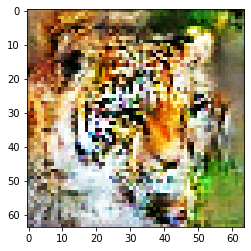

tf.Tensor(1.7435338, shape=(), dtype=float32)


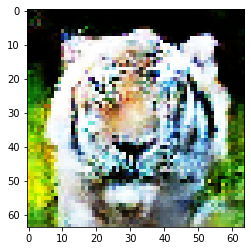

tf.Tensor(6.976904, shape=(), dtype=float32)


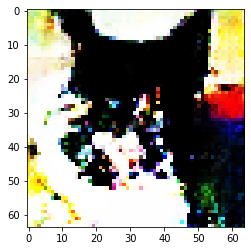

In [8]:
all_losses = []
for i in range(3):
    starting_noise = tf.random.truncated_normal([1, latent_dim])
    
    gradient_momentum_noise, gdm_losses =\
        gradient_descent_momentum(goal_prediction, starting_noise, 0.08, 0.9, 15, verbose=False)
    
    all_losses.append(gdm_losses)
    print(gdm_losses[-1])
    generated_image = generator(gradient_momentum_noise, training=False)[0]
    plt.imshow((generated_image[0].numpy()*127.5+127.5).astype("uint8"), interpolation="none")
    plt.show()

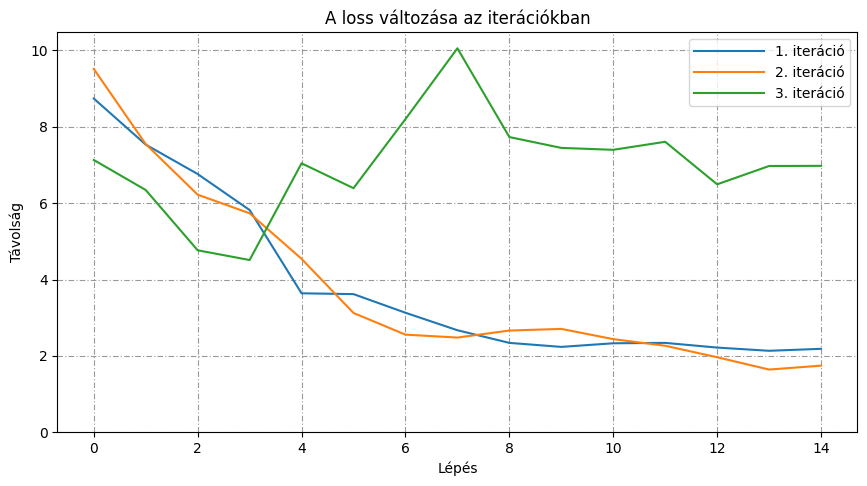

In [9]:
fig_1 = plt.figure(figsize=(8, 4), dpi=100)
ax = fig_1.add_axes([0, 0, 1, 1])
ax.set_xlabel('Lépés')
ax.set_ylabel('Távolság')
ax.set_title('A loss változása az iterációkban')

ax.grid(True, color='0.6', dashes=(5, 2, 1, 2))

for i in range(len(all_losses)):
    ax.plot(all_losses[i], label=str(i+1)+". iteráció")

ax.set_ylim(bottom=0)
ax.legend(loc=0, handlelength=5)

plt.show()